In [ ]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import shutil
import random
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict

In [ ]:
# Paths
image_dir = 'NIH_X_14/images-224'
train_txt = 'NIH_X_14/train_val_list_NIH.txt'
test_txt = 'NIH_X_14/test_list_NIH.txt'
output_base = 'NIH_X_14_Sorted'

# Output dirs
train_dir = os.path.join(output_base, 'train')
val_dir = os.path.join(output_base, 'val')
test_dir = os.path.join(output_base, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Read filenames from txt files
def read_filenames(txt_path):
    with open(txt_path, 'r') as f:
        return [line.strip() for line in f.readlines()]

train_files = read_filenames(train_txt)
test_files = read_filenames(test_txt)

# Move images to train/ and test/
def move_files(file_list, destination_dir, label, image_dir):
    print(f"Organising {label} set:")
    os.makedirs(destination_dir, exist_ok=True)

    for file_name in tqdm(file_list, desc=label):
        src = os.path.join(image_dir, file_name)
        dst = os.path.join(destination_dir, file_name)

        if os.path.exists(src):
            try:
                # Open image, convert to grayscale, and save
                img = Image.open(src).convert('L')  # 'L' mode for grayscale
                img.save(dst)
            except Exception as e:
                print(f"Failed to convert {file_name}: {e}")
        else:
            print(f"Warning: {file_name} not found in {image_dir}")

# Move files to train and test sets
move_files(train_files, train_dir, "Train", image_dir)

# Split the test set: 75% to validation and 25% to the test set
val_files = test_files[:int(0.75 * len(test_files))]  # 75% for validation
test_files = test_files[int(0.75 * len(test_files)):]  # The remaining 25% stays in test set

# Move validation files
move_files(val_files, val_dir, "Validation", image_dir)

# Move the remaining test files (no changes needed)
move_files(test_files, test_dir, "Test", image_dir)

print("Process Ended.")

In [ ]:
# Paths
csv_path = r'NIH_X_14\Data_Entry_2017.csv'
image_dir = r'NIH_X_14_Sorted/images'
output_base = r'NIH_X_14_Sorted'

# Output CSV paths
train_csv = os.path.join(output_base, 'train_labels.csv')
val_csv = os.path.join(output_base, 'val_labels.csv')
test_csv = os.path.join(output_base, 'test_labels.csv')

# Read the original CSV
df = pd.read_csv(csv_path)

# Ensure 'Image Index' exists in the CSV
if 'Image Index' not in df.columns:
    raise ValueError("CSV file must contain a column named 'Image Index'.")

# Get list of filenames from the 'Image Index' column
image_filenames = df['Image Index'].tolist()

# Read the filenames from each dataset directory (train, val, and test)
def read_filenames(directory):
    return [f for f in os.listdir(directory) if f.endswith('.png')]

# Ensure the paths exist and are accessible
train_files = read_filenames(r'NIH_X_14_Sorted\train')
val_files = read_filenames(r'NIH_X_14_Sorted\val')
test_files = read_filenames(r'NIH_X_14_Sorted\test')

# Create the 'split' column by checking where each image belongs
df['split'] = df['Image Index'].apply(lambda x: 'train' if x in train_files 
                                      else ('val' if x in val_files 
                                            else ('test' if x in test_files 
                                                  else 'unknown')))

# Handle any images that were not found in any of the sets
unknown_images = df[df['split'] == 'unknown']
if not unknown_images.empty:
    print(f"Warning: The following images were not found in any of the sets:\n{unknown_images['Image Index'].tolist()}")

# Now filter the DataFrame into train, val, and test DataFrames
train_df = df[df['split'] == 'train']
val_df = df[df['split'] == 'val']
test_df = df[df['split'] == 'test']

# Save the DataFrames to new CSV files
train_df.to_csv(train_csv, index=False)
val_df.to_csv(val_csv, index=False)
test_df.to_csv(test_csv, index=False)

print(f"Train CSV saved to: {train_csv}")
print(f"Validation CSV saved to: {val_csv}")
print(f"Test CSV saved to: {test_csv}")


In [ ]:
all_labels = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration',
    'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax',
    'Consolidation', 'Edema', 'Emphysema', 'Fibrosis',
    'Pleural_Thickening', 'Hernia'
]

def multi_hot_encode(filename):
    df = pd.read_csv(filename)
    df['Finding Labels'] = df['Finding Labels'].replace('No Finding', '')

    # Multi-hot encoding for all pathologies
    for label in tqdm(all_labels):
        df[label] = df['Finding Labels'].apply(lambda x: int(label in x.split('|')))

    # Add Healthy = 1 if all others are 0
    df['Healthy'] = df[all_labels].sum(axis=1).apply(lambda x: int(x == 0))

    # Create final label list with Healthy at the end
    all_labels_with_healthy = all_labels + ['Healthy']

    # Final encoded dataframe
    encoded_df = df[['Image Index'] + all_labels_with_healthy]
    encoded_df = encoded_df.rename(columns={'Image Index': 'Path'})

    # Save
    encoded_df.to_csv(fr'{os.path.splitext(filename)[0]}_encoded.csv', index=False)
    print(f"Encoded CSV saved with Healthy column: {os.path.splitext(filename)[0]}_encoded.csv")

# Apply to all splits
multi_hot_encode("NIH_X_14_Sorted/test_labels.csv")
multi_hot_encode("NIH_X_14_Sorted/train_labels.csv")
multi_hot_encode("NIH_X_14_Sorted/val_labels.csv")
multi_hot_encode("NIH_X_14/Data_Entry_2017.csv")


Pathology Occurrence Counts:
Healthy               60412
Infiltration          19870
Effusion              13307
Atelectasis           11535
Nodule                 6323
Mass                   5746
Pneumothorax           5298
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2772
Emphysema              2516
Edema                  2303
Fibrosis               1686
Pneumonia              1353
Hernia                  227
dtype: int64

Pathology Occurrence Percentages:
Healthy               53.88
Infiltration          17.72
Effusion              11.87
Atelectasis           10.29
Nodule                 5.64
Mass                   5.12
Pneumothorax           4.73
Consolidation          4.16
Pleural_Thickening     3.02
Cardiomegaly           2.47
Emphysema              2.24
Edema                  2.05
Fibrosis               1.50
Pneumonia              1.21
Hernia                 0.20
dtype: float64


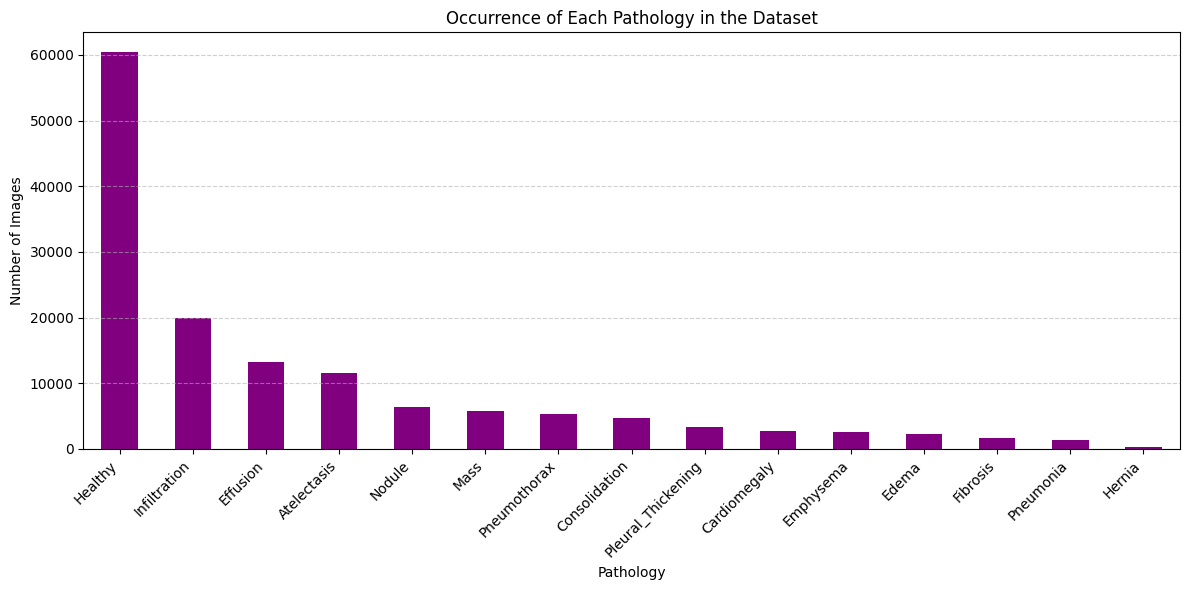

In [2]:
# Load encoded CSV
df = pd.read_csv(r'NIH_X_14/Data_Entry_2017_encoded.csv')

# Drop the image column to work only with labels
label_df = df.drop(columns=['Path'])

# Sum occurrences of each pathology
label_counts = label_df.sum().sort_values(ascending=False)

# Print label counts
print("Pathology Occurrence Counts:")
print(label_counts)

# Optional: also show % of total samples
label_percent = (label_counts / len(df)) * 100
print("\nPathology Occurrence Percentages:")
print(label_percent.round(2))

# Plot
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='purple')
plt.title('Occurrence of Each Pathology in the Dataset')
plt.ylabel('Number of Images')
plt.xlabel('Pathology')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [ ]:
label_df = pd.read_csv(r'NIH_X_14_Sorted/train_labels_encoded.csv')
label_array = label_df.drop(columns=['Path']).values  # Exclude filename column

# Count positive occurrences per class
pos_counts = np.sum(label_array, axis=0)
print("Original class distribution:\n", pos_counts)

target_count = int(np.median(pos_counts))

In [ ]:
image_paths = label_df['Path'].values
label_matrix = label_array
num_classes = label_matrix.shape[1]

class_to_images = defaultdict(list)

for idx, row in enumerate(label_matrix):
    for cls in range(num_classes):
        if row[cls] == 1:
            class_to_images[cls].append(image_paths[idx])

In [ ]:
balanced_image_set = set()

for cls in range(num_classes):
    images = class_to_images[cls]
    if len(images) < target_count:
        sampled = random.choices(images, k=target_count)  # oversample
    else:
        sampled = random.sample(images, k=target_count)   # undersample
    balanced_image_set.update(sampled)

In [ ]:
original_img_dir = 'NIH_X_14_Sorted/train'
output_img_dir = 'NIH_X_14_Balanced/train'
os.makedirs(output_img_dir, exist_ok=True)

balanced_label_df = label_df[label_df['image'].isin(balanced_image_set)]

for img_name in tqdm(balanced_label_df['image']):
    src = os.path.join(original_img_dir, img_name)
    dst = os.path.join(output_img_dir, img_name)
    shutil.copy2(src, dst)

# Save new label file
balanced_label_df.to_csv('NIH_X_14_Balanced/train_labels_encoded.csv', index=False)

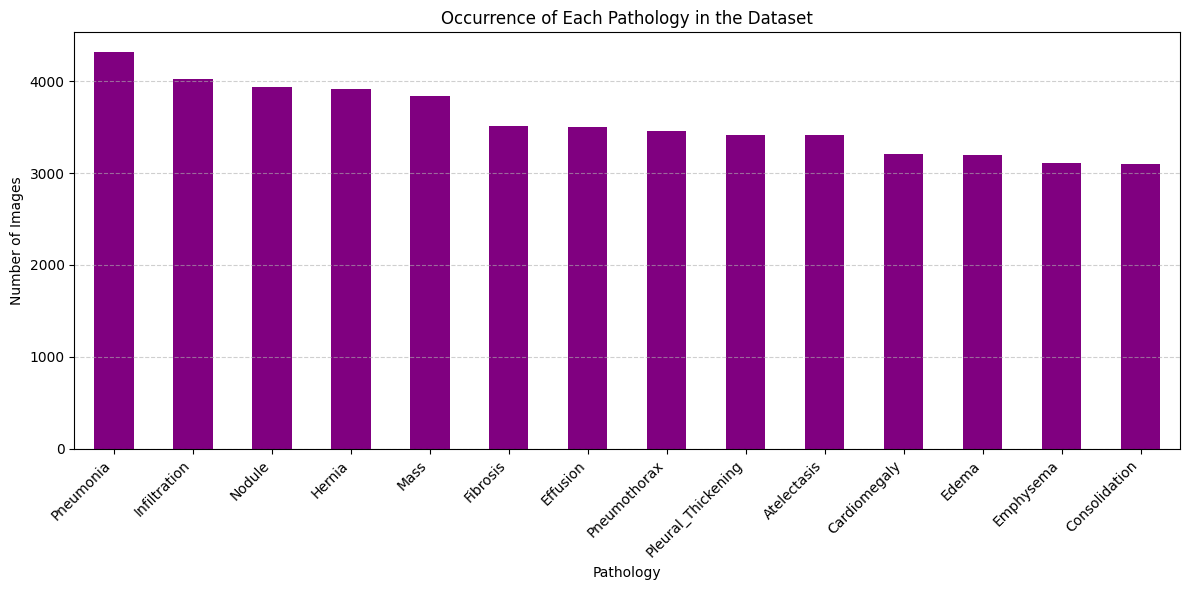

In [3]:
# Load encoded CSV
df = pd.read_csv(r'NIH_X_14_Balanced\train_labels_encoded.csv')

# Drop the image column to work only with labels
label_df = df.drop(columns=['Path'])

# Sum occurrences of each pathology
label_counts = label_df.sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='purple')
plt.title('Occurrence of Each Pathology in the Dataset')
plt.ylabel('Number of Images')
plt.xlabel('Pathology')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [ ]:
def shrink(original_image_dir, original_csv_path, output_image_dir, output_csv_path, num_samples):

    # === SETUP ===
    os.makedirs(output_image_dir, exist_ok=True)

    # === LOAD CSV ===
    df = pd.read_csv(original_csv_path)

    # === RANDOM SUBSET ===
    subset_df = df.sample(n=num_samples, random_state=14)

    # === COPY IMAGES ===
    for filename in tqdm(subset_df['Path']):

        src = os.path.join(original_image_dir, filename)
        dst = os.path.join(output_image_dir, filename)
        if os.path.exists(src):
            shutil.copy2(src, dst)
        else:
            print(f"Warning: File not found -> {filename}")

    # === SAVE NEW CSV ===
    subset_df.to_csv(output_csv_path, index=False)

    print(f"Subset of {len(subset_df)} images and labels saved.")


In [ ]:
shrink(r"NIH_X_14_Sorted\train", r"NIH_X_14_Sorted\train_labels_encoded.csv", r"NIH_X_14_Small\train", r"NIH_X_14_Small\train_labels_encoded.csv", 8000)
shrink(r"NIH_X_14_Sorted\test", r"NIH_X_14_Sorted\test_labels_encoded.csv", r"NIH_X_14_Small\test", r"NIH_X_14_Small\test_labels_encoded.csv", 500)
shrink(r"NIH_X_14_Sorted\val", r"NIH_X_14_Sorted\val_labels_encoded.csv", r"NIH_X_14_Small\val", r"NIH_X_14_Small\val_labels_encoded.csv", 2500)

In [ ]:
def remove_healthy(original_image_dir, original_csv_path, output_image_dir, output_csv_path):

    # === SETUP ===
    os.makedirs(output_image_dir, exist_ok=True)

    # === LOAD CSV ===
    df = pd.read_csv(original_csv_path)
    filtered_df = df[df[all_labels].sum(axis=1) > 0]

    for filename in tqdm(filtered_df['Path']):

        src = os.path.join(original_image_dir, filename)
        dst = os.path.join(output_image_dir, filename)

        if os.path.exists(src):
            shutil.copy2(src, dst)
        else:
            print(f"Warning: File not found -> {filename}")

    # === SAVE NEW CSV ===
    filtered_df.to_csv(output_csv_path, index=False)

    print(f"Filtered subset of {len(filtered_df)} images and labels saved.")

all_labels = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration',
    'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax',
    'Consolidation', 'Edema', 'Emphysema', 'Fibrosis',
    'Pleural_Thickening', 'Hernia'
]



In [ ]:
remove_healthy(r"NIH_X_14_Sorted\train", r"NIH_X_14_Sorted\train_labels_encoded.csv", r"NIH_X_14_Filtered\train", r"NIH_X_14_Filtered\train_labels_encoded.csv")
remove_healthy(r"NIH_X_14_Sorted\test", r"NIH_X_14_Sorted\test_labels_encoded.csv", r"NIH_X_14_Filtered\test", r"NIH_X_14_Filtered\test_labels_encoded.csv")
remove_healthy(r"NIH_X_14_Sorted\val", r"NIH_X_14_Sorted\val_labels_encoded.csv", r"NIH_X_14_Filtered\val", r"NIH_X_14_Filtered\val_labels_encoded.csv")